In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype


import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set(style="darkgrid")

#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = "../../../data/house_pricing/"

In [3]:
df_train=pd.read_csv(f'{PATH}train.csv', index_col='Id')
df_test=pd.read_csv(f'{PATH}test.csv', index_col='Id')

In [4]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['SalePrice'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 80)
Training y Shape = 1460

Test X Shape = (1459, 79)
Test y Shape = 1459

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Funct

In [5]:
print(df_train.info())
df_train.sample(3)
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1748          60       RL         80.0    10400   Pave   NaN      Reg   
2739          80       RL          NaN    12700   Pave   NaN      IR1   
1552          50       RM         57.0     8094   Pave  Grvl      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1748         Lvl    AllPub    Inside  ...         168        0    NaN    NaN   
2739         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1552         Lvl    AllPub    Inside  ...           0        0    NaN  GdPrv   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1748         NaN       0       5    2009        WD         Normal  
2739         NaN       0      11    2006        WD         Normal  
1552         NaN       0       6    2010        WD         Normal  

[3 rows x 79 columns]

# Dealing with Outliers

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### -> To delete outliers

In [7]:
#Correlations with Target value

# Dealing with Missing Values

[]

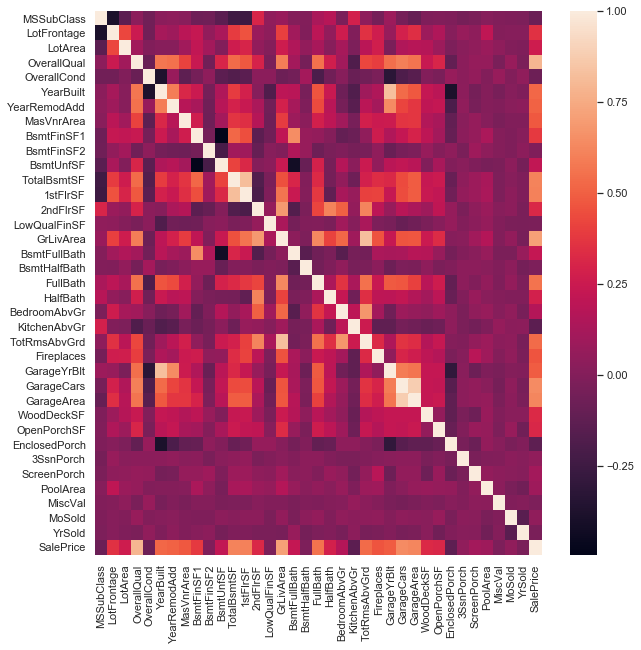

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr())
plt.plot()

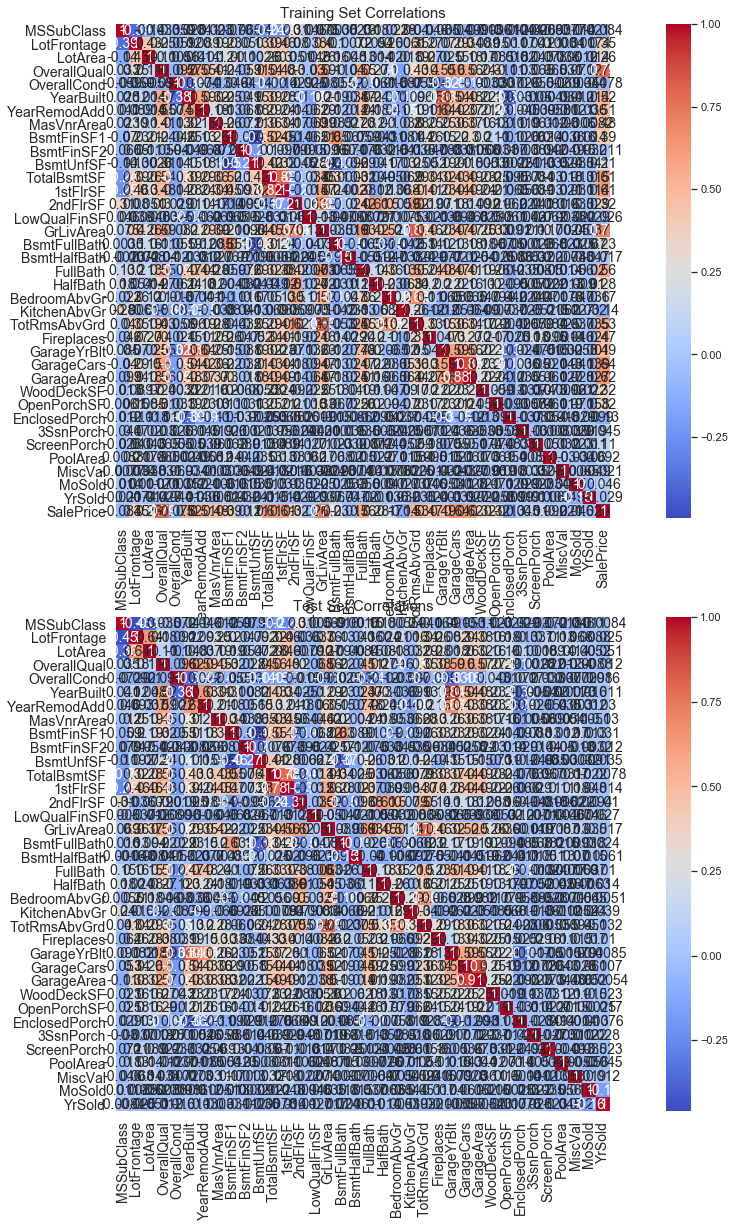

In [9]:
#df_train.corr().sort().abs()
"""
df_train_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]
"""

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [10]:
df_corr=df_train.corr().sort_values(kind="quicksort", ascending=False, by='SalePrice').abs()
df_corr.drop(axis=1, columns=df_corr.columns.drop('SalePrice'), inplace=True)
df_corr

SalePrice
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2      0.011378
BsmtHalfBath    0.016844
MiscVal         0.021190
LowQualFinSF    0.025606
YrSold          0.028923
OverallCond     0.077856
MSSubClass      0.084284
EnclosedPorch   0.128578
KitchenAbvGr    0.135907

In [11]:
# df_train['Alley'].isnull().sum() = show number of NaN rows in 'Alley' column

In [12]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

df_all.shape

(2919, 80)

In [13]:
y_train = df_train.SalePrice.values
df_all.drop(['SalePrice'], axis=1, inplace=True)

In [14]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
for df in dfs:
    print(format(df.name))
    display_missing(df)
    
    
    
#Check remaining missing values if any 
def display_only_missing(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print(missing_data.head())

Training Set
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1369
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 8
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1453
Fence 1179
MiscFeature 1406
MiscVal 0
MoSold

In [15]:
"""### Dealing with missing values
to improve in future - may be not median of overall but 
Missing values in 'LotFrontage' feature are filled with the median LotFrontage, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481) features
"""

"### Dealing with missing values\nto improve in future - may be not median of overall but \nMissing values in 'LotFrontage' feature are filled with the median LotFrontage, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481) features\n"

In [16]:
df_train['OverallQual'].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

In [17]:
#df_train_copy=df_train['LotFrontage'].copy()
    #df_train_copy
#df_train_copy.fillna(value=df_train['LotFrontage'].mean())

In [18]:
#df_train['LotFrontage'].mean()

In [19]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [20]:
df_all.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
0       856       854          0   NaN             3     1Fam       TA   
1      1262         0          0   NaN             3     1Fam       TA   
2       920       866          0   NaN             3     1Fam       TA   
3       961       756          0   NaN             3     1Fam       Gd   
4      1145      1053          0   NaN             4     1Fam       TA   

  BsmtExposure  BsmtFinSF1  BsmtFinSF2  ... SaleType ScreenPorch  Street  \
0           No       706.0         0.0  ...       WD           0    Pave   
1           Gd       978.0         0.0  ...       WD           0    Pave   
2           Mn       486.0         0.0  ...       WD           0    Pave   
3           No       216.0         0.0  ...       WD           0    Pave   
4           Av       655.0         0.0  ...       WD           0    Pave   

   TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
0             8       856.0     AllPub          0      2003         2003   
1             6      1262.0     AllPub        298      1976         1976   
2             6       920.0     AllPub          0      2001         2002   
3             7       756.0     AllPub          0      1915         1970   
4             9      1145.0     AllPub        192      2000         2000   

  YrSold  
0   2008  
1   2007  
2   2008  
3   2006  
4   2008  

[5 rows x 79 columns]

In [21]:
# change NA values in test set - to median
def nan_to_mean(df):
    for col in df.columns:
        if is_numeric_dtype(col):
            df[col].fillna(value=df[col].median(), inplace=True)
            print(col, df[col].median())
            
nan_to_mean(df)

display_missing(df_all)

1stFlrSF 0
2ndFlrSF 0
3SsnPorch 0
Alley 2721
BedroomAbvGr 0
BldgType 0
BsmtCond 82
BsmtExposure 82
BsmtFinSF1 1
BsmtFinSF2 1
BsmtFinType1 79
BsmtFinType2 80
BsmtFullBath 2
BsmtHalfBath 2
BsmtQual 81
BsmtUnfSF 1
CentralAir 0
Condition1 0
Condition2 0
Electrical 1
EnclosedPorch 0
ExterCond 0
ExterQual 0
Exterior1st 1
Exterior2nd 1
Fence 2348
FireplaceQu 1420
Fireplaces 0
Foundation 0
FullBath 0
Functional 2
GarageArea 1
GarageCars 1
GarageCond 159
GarageFinish 159
GarageQual 159
GarageType 157
GarageYrBlt 159
GrLivArea 0
HalfBath 0
Heating 0
HeatingQC 0
HouseStyle 0
KitchenAbvGr 0
KitchenQual 1
LandContour 0
LandSlope 0
LotArea 0
LotConfig 0
LotFrontage 486
LotShape 0
LowQualFinSF 0
MSSubClass 0
MSZoning 4
MasVnrArea 23
MasVnrType 24
MiscFeature 2814
MiscVal 0
MoSold 0
Neighborhood 0
OpenPorchSF 0
OverallCond 0
OverallQual 0
PavedDrive 0
PoolArea 0
PoolQC 2909
RoofMatl 0
RoofStyle 0
SaleCondition 0
SaleType 1
ScreenPorch 0
Street 0
TotRmsAbvGrd 0
TotalBsmtSF 1
Utilities 2
WoodDeckSF 0
Ye

In [22]:
#Imputing NA values, based on Data description for Pool existance, ...

df_all["PoolQC"] = df_all["PoolQC"].fillna("None")

In [23]:
#all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
#all_data["Alley"] = all_data["Alley"].fillna("None")
#all_data["Fence"] = all_data["Fence"].fillna("None")
#all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
# ...

#fill value with None - based on data description -  - for non-Numerical (object) Columns
for col in ('MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType','MSSubClass'):
    df_all[col] = df_all[col].fillna('None')
    
#fill value with '0' - based on data description - for Numerical Columns
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)
    

In [24]:
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
df_all = df_all.drop(['Utilities'], axis=1)


In [25]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.649538
MSZoning          0.137033
Functional        0.068517
SaleType          0.034258
KitchenQual       0.034258


In [26]:
df_all['LotFrontage'].median

<bound method Series.median of 0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
        ...  
2914     21.0
2915     21.0
2916    160.0
2917     62.0
2918     74.0
Name: LotFrontage, Length: 2919, dtype: float64>

In [27]:
"""
# !for the begining I use just median of whole Dataset!

### -> in future try to use grouped median by neighborhood
LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
"""

df_all['LotFrontage']=df_all['LotFrontage'].fillna(df_all['LotFrontage'].median).astype(str)


In [28]:
df_all['LotFrontage']

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
        ...  
2914     21.0
2915     21.0
2916    160.0
2917     62.0
2918     74.0
Name: LotFrontage, Length: 2919, dtype: object

In [29]:
display_only_missing(df_all)

             Missing Ratio
MSZoning          0.137033
Functional        0.068517
SaleType          0.034258
KitchenQual       0.034258
Exterior2nd       0.034258


In [30]:
# find most frequent value for MSZoning
df_all.MSZoning.mode()

0    RL
dtype: object

In [31]:
#all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
#all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
#all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
#all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
#all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
#all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    df_all[col]=df_all[col].mode()[0]

In [32]:
display_only_missing(df_all)

            Missing Ratio
Functional       0.068517


In [33]:
#Functional : data description says NA means typical
df_all["Functional"] = df_all["Functional"].fillna("Typ")

In [34]:
display_only_missing(df_all)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


### Seems no missed values, except SalePrice from Test DataSet
Missing Values = DONE

# Dealing with categorical values

In [35]:
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [36]:
train_cats(df_all)

In [37]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 78 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null category
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null category
BsmtCond         2919 non-null category
BsmtExposure     2919 non-null category
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null category
BsmtFinType2     2919 non-null category
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null category
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null category
Condition1       2919 non-null category
Condition2       2919 non-null category
Electrical       2919 non-null category
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null category
ExterQual        2919 non-null ca

In [38]:
df_all.YrSold

0       2008
1       2007
2       2008
3       2006
4       2008
        ... 
2914    2006
2915    2006
2916    2006
2917    2006
2918    2006
Name: YrSold, Length: 2919, dtype: int64

In [39]:
#Transforming some numerical variables that are really categorical

#MSSubClass=The building class
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
df_all['OverallCond'] = df_all['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
df_all['YrSold'] = df_all['YrSold'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

## Label Encoding

In [40]:
from sklearn.preprocessing import LabelEncoder
for col in df_all.columns:
    if is_categorical_dtype(col):
        print(col)

In [41]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_all[c].values)) 
    df_all[c] = lbl.transform(list(df_all[c].values))

# shape        
print('Shape all_data: {}'.format(df_all.shape))

Shape all_data: (2919, 78)


In [42]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 78 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null int64
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null category
BsmtCond         2919 non-null int64
BsmtExposure     2919 non-null int64
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null int64
BsmtFinType2     2919 non-null int64
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null int64
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null int64
Condition1       2919 non-null category
Condition2       2919 non-null category
Electrical       2919 non-null category
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null int64
ExterQual        2919 non-null int64
Exterior1st      291

In [43]:
df_all=pd.get_dummies(df_all)

# Normalization

In [44]:
#Normalization, the Sigmoid, Log, Cube Root and the Hyperbolic Tangent. 
#It all depends on what one is trying to accomplish.

# Machine Learning

In [45]:
df_all.head()

1stFlrSF  2ndFlrSF  3SsnPorch  Alley  BedroomAbvGr  BsmtCond  BsmtExposure  \
0       856       854          0      1             3         4             3   
1      1262         0          0      1             3         4             1   
2       920       866          0      1             3         4             2   
3       961       756          0      1             3         1             3   
4      1145      1053          0      1             4         4             0   

   BsmtFinSF1  BsmtFinSF2  BsmtFinType1  ...  RoofStyle_Hip  \
0       706.0         0.0             2  ...              0   
1       978.0         0.0             0  ...              0   
2       486.0         0.0             2  ...              0   
3       216.0         0.0             0  ...              0   
4       655.0         0.0             2  ...              0   

   RoofStyle_Mansard  RoofStyle_Shed  SaleCondition_Abnorml  \
0                  0               0                      0   
1                  0               0                      0   
2                  0               0                      0   
3                  0               0                      1   
4                  0               0                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  SaleType_WD  
0                     1                      0            1  
1                     1                      0            1  
2                     1                      0            1  
3                     0                      0            1  
4                     1                      0            1  

[5 rows x 303 columns]

In [ ]:
#y=df_all['SalePrice']

In [ ]:
"""Dividing working DataFrame back to Train and Test"""

df_all.drop('SalePrice',axis=1, inplace=True)
X_valid_testset=df_all.iloc[1460:] # split Validational/Test set from Training set after Categorical Value Engeneering
X_train=df_all.iloc[:1460]
y_train=y[:1460]

In [ ]:
df.shape, y.shape, X_valid_testset.shape

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

# Old version Machine Learning - with just dropNA and dropCategorical

In [ ]:
#Dele
df_train_no_obj=df_train.select_dtypes(exclude=['object'])
df_test_no_obj=df_test.select_dtypes(exclude=['object'])

In [ ]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
display_missing(df_test_no_obj)

In [ ]:
#drop NA values in train set - for time save
df_train_no_obj.dropna(inplace=True)
#df_test_no_obj.dropna(inplace=True)

In [ ]:
# change NA values in test set - to mean
def nan_to_mean(df):
    for col in df.columns:
        df[col].fillna(value=df[col].mean(), inplace=True)
        print(col, df[col].mean())
        
nan_to_mean(df_test_no_obj)

In [ ]:
display_missing(df_test_no_obj)

In [ ]:
y_train = df_train_no_obj['SalePrice'].values
drop_columns= ['SalePrice']#,'Id']
X_train = df_train_no_obj.drop(columns=drop_columns)
#X_val= df_test_no_obj.drop(columns='Id')
X_val= df_test_no_obj

In [ ]:
y_train.shape

In [ ]:
y_train=y_train.reshape(-1,1)
#X_train_no_obj.dropna(inplace=True)
X_train=X_train.astype(np.float32)
X_val=X_val.astype(np.float32)

In [ ]:
X_val.shape

In [ ]:
X_val

In [ ]:
forest_model = RandomForestRegressor()

#forest_model = RandomForestClassifier
forest_model.fit(X_train, y_train)
forest_model.score(X_train, y_train)
y_pred = forest_model.predict(X_val)
#print(mean_squared_error(y_val, survival_preds))
#print(mean_absolute_error(y_val, survival_preds))

In [ ]:
forest_model.score(X_train, y_train)

# Submission

In [ ]:
submission_df = pd.DataFrame(columns=['Id', 'SalePrice'])
submission_df['Id'] = df_test_no_obj['Id']
submission_df['SalePrice'] = y_pred
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)